# 🎓 Sesiunea 8 — Multiple & Polynomial Regression
**Obiectiv:** Înțelegem și implementăm regresia liniară *multivariată* și *polinomială* — întâi formulă și implementare *manuală* (gradient descent), apoi folosim și `scikit-learn` pentru comparație.

## 0) Statement-ul problemei

- Avem **m** exemple de antrenare, fiecare cu **n** features.  


| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|-------------- |  
| 2104            | 5                   | 1                | 45           | 460           |  
| 1416            | 3                   | 2                | 40           | 232           |  
| 852             | 2                   | 1                | 35           | 178           |  

## 1) 🔹 Matricea de intrare (Design Matrix)

$$\mathbf{X} =
\begin{pmatrix}
x^{(0)}_0 & x^{(0)}_1 & \cdots & x^{(0)}_{n-1} \\
x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_{n-1} \\
\vdots & \vdots & \ddots & \vdots \\
x^{(m-1)}_0 & x^{(m-1)}_1 & \cdots & x^{(m-1)}_{n-1}
\end{pmatrix}
$$

unde:

- $\mathbf{x}^{(i)}$  este vectorul care conține exemplul i. $\mathbf{x}^{(i)}$ $ = (x^{(i)}_0, x^{(i)}_1, \cdots,x^{(i)}_{n-1})$
- $x^{(i)}_j$  este elementul **j** din exemplul **i**.
  - *Superscriptul* (în paranteză) → numărul exemplului  
  - *Subscriptul* → poziția elementului în vector


## 2) Funcția de cost și Gradient Descent
**Funcția de cost:**  
\\[ J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} \big(h_\theta(x^{(i)}) - y^{(i)}\big)^2. \\]

**Regula de update (simultan pentru fiecare \\(\theta_j\\)):**  
\\[ \theta_j := \theta_j - \alpha \cdot \frac{1}{m} \sum_{i=1}^{m} \big(h_\theta(x^{(i)}) - y^{(i)}\big) \cdot x_j^{(i)}. \\]

> 🎯 Vom implementa **manual** Gradient Descent și vom vizualiza scăderea lui \\(J(theta)\\).


## 3) Set de date (Housing) — mic, controlabil
Pentru claritate (și calcule rapide), generăm un *mini-dataset* inspirat de problema prețului casei.
- x₁: suprafață (m²)
- x₂: nr. dormitoare
- x₃: vechime (ani)

Target **y** (mii €) este generat cu o relație liniară + zgomot ușor, ca să putem valida antrenarea.


In [ ]:
sheet_id = "1tMH9pgVEolCZuwerAgwsDSEvxlKIszjt"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"

import pandas as pd
df = pd.read_csv(url)
df.head()

,size_m2,bedrooms,age_years,price_kEUR
0,91.757509,2,29.065805,123.227654
1,50.100640,2,32.614008,59.503736
2,112.137935,4,20.848894,160.417816
3,122.153782,4,24.342525,199.175477
4,35.000000,1,31.284865,46.345966


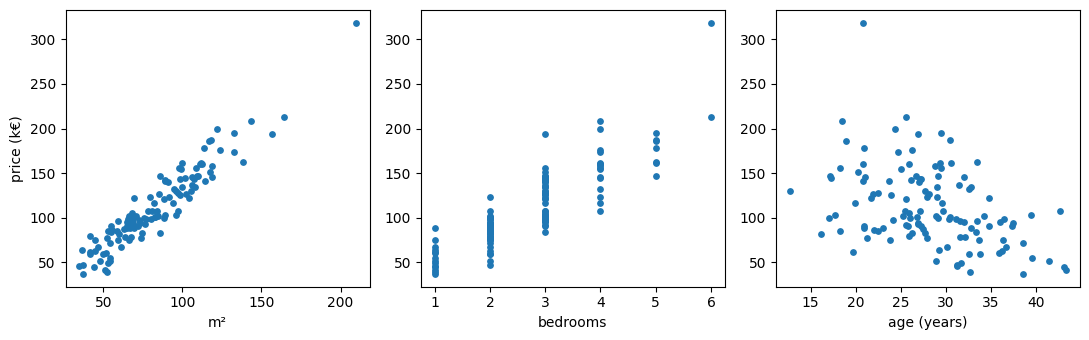

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(11,3.5))
axs[0].scatter(df.size_m2, df.price_kEUR, s=15); axs[0].set_xlabel("m²"); axs[0].set_ylabel("price (k€)")
axs[1].scatter(df.bedrooms, df.price_kEUR, s=15); axs[1].set_xlabel("bedrooms")
axs[2].scatter(df.age_years, df.price_kEUR, s=15); axs[2].set_xlabel("age (years)")
plt.tight_layout(); plt.show()


## ✂️  Împărțirea datelor în seturi de antrenare și testare

În învățarea automată, împărțim datele în două părți:
- **Train set** → modelul *învață* relațiile dintre variabile.  
- **Test set** → verificăm cât de bine *generalizează* modelul pe date noi, nevăzute.

---

### 🔹 De ce facem asta?
Dacă am antrena și evalua modelul pe aceleași date:
- modelul ar învăța pe de rost valorile (*overfitting*),
- am obține o acuratețe falsă.

Scopul e să simulăm o situație reală:  
modelul a văzut doar „train”, dar trebuie să performeze bine și pe „test”.

---



In [ ]:
from sklearn.model_selection import train_test_split

# Alegem features și target
X = df[["size_m2", "bedrooms", "age_years"]]
y = df["price_kEUR"]

# Împărțim în 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 Dimensiunea seturilor:")
print(f"Train: {X_train.shape[0]} exemple")
print(f"Test:  {X_test.shape[0]} exemple")


📊 Dimensiunea seturilor:
Train: 96 exemple
Test:  24 exemple


## 4) Feature scaling (Standardizare)
**De ce?** Fără scalare, contururile costului sunt eliptice ⇒ **GD devine lent/instabil**.

Vom folosi: \\( z = \frac{x - \mu}{\sigma} \\)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# adăugăm 1 pentru bias
def add_bias(X):
    import numpy as np
    return np.c_[np.ones((X.shape[0], 1)), X]

Xb_train = add_bias(X_train_s)
Xb_test = add_bias(X_test_s)

Xb_train[:3]

array([[ 1.        , -0.75541764,  0.270232  ,  0.75138681],
       [ 1.        ,  0.00726399,  1.19674173,  0.14940533],
       [ 1.        , -0.91879029, -0.65627772,  1.57007129]])

## 5) Implementare manuală: Gradient Descent
Vom scrie funcții pentru:
- ipoteză, cost \\(J(theta)\\)
- un pas de GD
- rulare pe epoci + istoric cost





In [ ]:
import numpy as np

def hypothesis(Xb, theta):
    return np.dot(Xb, theta)

def cost_J(Xb, y, theta):
    m = len(y)
    residuals = hypothesis(Xb, theta) - y
    cost = np.dot(residuals, residuals) / (2 * m)
    return cost

def gradient_step(Xb, y, theta, alpha):
    m = len(y)
    residuals = hypothesis(Xb, theta) - y
    grad = np.dot(Xb.T, residuals) / m     # X^T * (hθ(x) - y)
    theta_new = theta - alpha * grad       # actualizare parametri
    return theta_new

def fit_gd(Xb, y, alpha=0.05, epochs=1000, theta0=None):
    n_params = Xb.shape[1]  # nr de parametri (inclusiv bias)
    theta = np.zeros(n_params) if theta0 is None else theta0.copy()  # inițializare
    history = []  # salvăm cum scade eroarea

    for ep in range(epochs):  # repetăm de 'epochs' ori
        theta = gradient_step(Xb, y, theta, alpha)  # facem un pas de gradient descent

        # din 10 în 10 epoci salvăm valoarea funcției de cost
        if ep % 10 == 0 or ep == epochs-1:
            history.append(cost_J(Xb, y, theta))

    return theta, np.array(history)  # parametrii finali + istoricul costului


theta_gd, hist = fit_gd(Xb_train, y_train, alpha=0.01, epochs=1500)
theta_gd, hist[:5], hist[-5:]

(array([111.14592529,  31.10470736,  12.9131214 ,  -4.38817517]),
 array([7041.15023334, 5640.64924805, 4539.21089195, 3667.65892151,
        2974.3192481 ]),
 array([60.78994584, 60.78773364, 60.78560747, 60.78356398, 60.78179288]))

### Vizualizare convergență J(θ)
Dacă α e prea mare, costul poate oscila sau crește. Dacă e prea mic, scăderea e lentă.


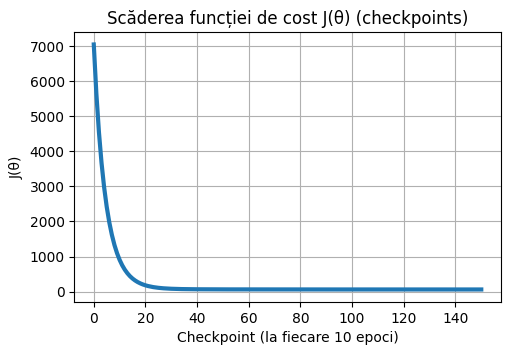

In [ ]:
plt.figure(figsize=(5.5,3.5))
plt.plot(hist, linewidth=3)
plt.title('Scăderea funcției de cost J(θ) (checkpoints)')
plt.xlabel('Checkpoint (la fiecare 10 epoci)')
plt.ylabel('J(θ)')
plt.grid(True)
plt.show()

### Linear Regression folosind sklearn

In [ ]:
# Linear Regression (univariată): size_m2 -> price_kEUR
# Ținta: să avem o celulă cât mai simplă, cu pașii expliciți și un singur MSE (pe test).

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1) Aleg feature-ul (X) și ținta (y) din dataframe-ul tău 'df'
X = df[['size_m2']].values          # coloană 2D (n, 1)
y = df['price_kEUR'].values         # vector 1D (n,)

# 2) Împart datele în train (80%) și test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# 3) Creez și antrenez modelul liniar pe setul de antrenare
model = LinearRegression()
model.fit(X_train, y_train)

# 4) Fac predicții pe setul de test
y_pred_test = model.predict(X_test)

In [ ]:
# 5) Calculez eroarea medie pătratică (MSE) DOAR pe test
mse_test = mean_squared_error(y_test, y_pred_test)

# 6) Afișez parametrii modelului + MSE pe test
print("=== Linear Regression (univariată) ===")
print(f"Coeficient (slope):  {model.coef_[0]:.6f}")
print(f"Intercept (bias):    {model.intercept_:.6f}")
print(f"MSE (test):          {mse_test:.6f}")

=== Linear Regression (univariată) ===
Coeficient (slope):  1.419830
Intercept (bias):    -5.553552
MSE (test):          236.409289


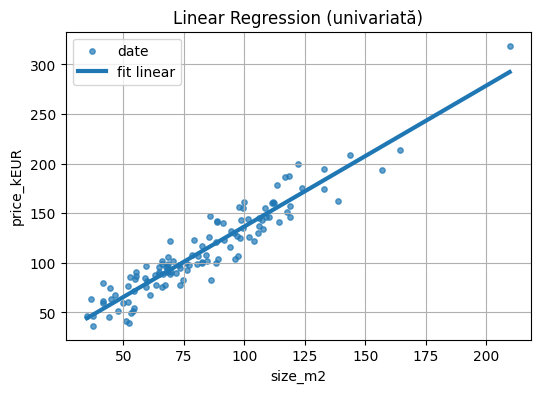

In [ ]:
# 7) Vizualizare: punctele + linia de regresie
xs = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)  # grid pe axa X
ys = model.predict(xs)                                  # linia estimată

plt.figure(figsize=(6,4))
plt.scatter(X, y, s=15, alpha=0.7, label='date')
plt.plot(xs, ys, linewidth=3, label='fit linear')
plt.xlabel('size_m2')
plt.ylabel('price_kEUR')
plt.title('Linear Regression (univariată)')
plt.legend()
plt.grid(True)
plt.show()


### Multiple Linear Regression

In [ ]:
# === Multiple Linear Regression (simplificată) ===
# Scop: prezicem 'price_kEUR' pe baza tuturor coloanelor numerice disponibile (mai puțin ținta)

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1) Alegem feature-urile (X) și ținta (y)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target_col = 'price_kEUR'
feature_cols = [c for c in num_cols if c != target_col]

X = df[feature_cols].values
y = df[target_col].values

# 2) Împărțim datele în train (80%) și test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 3) Antrenăm modelul de regresie liniară
model = LinearRegression()
model.fit(X_train, y_train)

# 4) Facem predicții pe test
y_pred = model.predict(X_test)


In [ ]:
# 5) Calculăm eroarea MSE
mse = mean_squared_error(y_test, y_pred)

# 6) Afișăm rezultatele
print("=== Multiple Linear Regression ===")
print("Features folosite:", feature_cols)
print("Coeficienți:", np.round(model.coef_, 4))
print("Intercept:", round(model.intercept_, 4))
print("MSE (test):", round(mse, 4))


=== Multiple Linear Regression ===
Features folosite: ['size_m2', 'bedrooms', 'age_years']
Coeficienți: [ 1.0428 11.5106 -0.6876]
Intercept: 13.9773
MSE (test): 124.3198


### Polynomial Regression

In [ ]:
# Polynomial Regression (multivariată) — simplificat
# Ideea: luăm TOATE feature-urile numerice, generăm termeni polinomiali (x, x^2, x_i*x_j, ...),
# apoi antrenăm un LinearRegression pe aceste feature-uri extinse.

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

degree = 2

# 1) Selectăm toate coloanele numerice ca X, iar 'price_kEUR' ca y
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target_col = 'price_kEUR'
feature_cols = [c for c in num_cols if c != target_col]

X = df[feature_cols].values
y = df[target_col].values

In [ ]:
# 2) Construim feature-uri polinomiale (include_bias=False ca să nu mai adăugăm manual coloana de 1)
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X)

# 3) Împărțim în train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

# 4) Antrenăm modelul liniar pe feature-urile polinomiale
model = LinearRegression()
model.fit(X_train, y_train)

# 5) Prezicem pe test și calculăm MSE (o singură metrică, simplu)
y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mse

111.26787294901719

In [ ]:
# 6) Afișăm un rezumat
print(f"=== Polynomial Regression (multivariată, degree={degree}) ===")
print("Features de bază:", feature_cols)
print("Nr. feature-uri după expandare polinomială:", X_poly.shape[1])
print(f"MSE (test): {mse:.4f}")

=== Polynomial Regression (multivariată, degree=2) ===
Features de bază: ['size_m2', 'bedrooms', 'age_years']
Nr. feature-uri după expandare polinomială: 9
MSE (test): 111.2679


In [ ]:
# Afișăm coeficienții și termenii polinomiali
feature_names = poly.get_feature_names_out(feature_cols)

for name, coef in zip(feature_names, model.coef_):
    print(f"{name}: {coef}")

print("\nIntercept (termenul liber):", model.intercept_)


size_m2: 0.09375038207714799
bedrooms: 41.40117256356791
age_years: 1.435603001024299
size_m2^2: 0.0024028798598791923
size_m2 bedrooms: 0.034614005418563965
size_m2 age_years: 0.01284799879619758
bedrooms^2: -2.5063092378730447
bedrooms age_years: -0.6254228540473888
age_years^2: -0.02680166829521169

Intercept (termenul liber): -14.640077095514542
